# Загрузка изображений флуоресцентных каналов и маски ядер

In [1]:
from load_imgs_from_folder import load_images_from_folder
imgs_names, imgs = load_images_from_folder(r'tiled_data', ['Stitched_cropped', 'BW_cluster_solo'], '*.tif')

In [2]:
imgs_names

[['pano_CD3e.tif',
  'pano_CD4.tif',
  'pano_CD8.tif',
  'pano_DAPI.tif',
  'pano_Ki67.tif'],
 ['BW_summary_Stardist_from_I_nuclei.tif']]

In [4]:
I_CD3e = imgs[0][0]
I_CD4 = imgs[0][1]
I_CD8 = imgs[0][2]
I_Ki67 = imgs[0][4]
BW_nuclei = imgs[1][0]

Толщина мембраны составляет примерно 5 пикселей. Используем expand_labels с размером равным 5 и подсчитаем **средние интенсивности** для каждого объекта

In [5]:
from skimage.measure import label
from _expand_labels import expand_labels #опять несовместимость версии библиотеки skimage 0.19 с Anaconda
label_nuclei, nuclei_num = label(BW_nuclei, return_num=True)
label_nuclei_expanded = expand_labels(label_nuclei, distance=5)

In [6]:
from skimage.measure import regionprops

rp = regionprops(label_nuclei_expanded) # используем bbox для снижения объема вычислений

stats = np.zeros((nuclei_num, 4)) # матрица для сохранения статистики
for i in range(1, nuclei_num + 1):
    (min_row, min_col, max_row, max_col) = rp[i - 1].bbox
    
    BW_object = np.array((label_nuclei == i), dtype=bool)
    
    CD3e_object = I_CD3e & BW_object
    CD3e_object = CD3e_object[min_row:max_row, min_col:max_col]
    
    CD4_object = I_CD4 & BW_object
    CD4_object = CD4_object[min_row:max_row, min_col:max_col]
    
    CD8_object = I_CD8 & BW_object
    CD8_object = CD8_object[min_row:max_row, min_col:max_col]
    
    Ki67_object = I_Ki67 & BW_object
    Ki67_object = Ki67_object[min_row:max_row, min_col:max_col]
    
    stats[i-1, :] = [np.mean(CD3e_object),
                    np.mean(CD4_object),
                    np.mean(CD8_object),
                    np.mean(Ki67_object)]

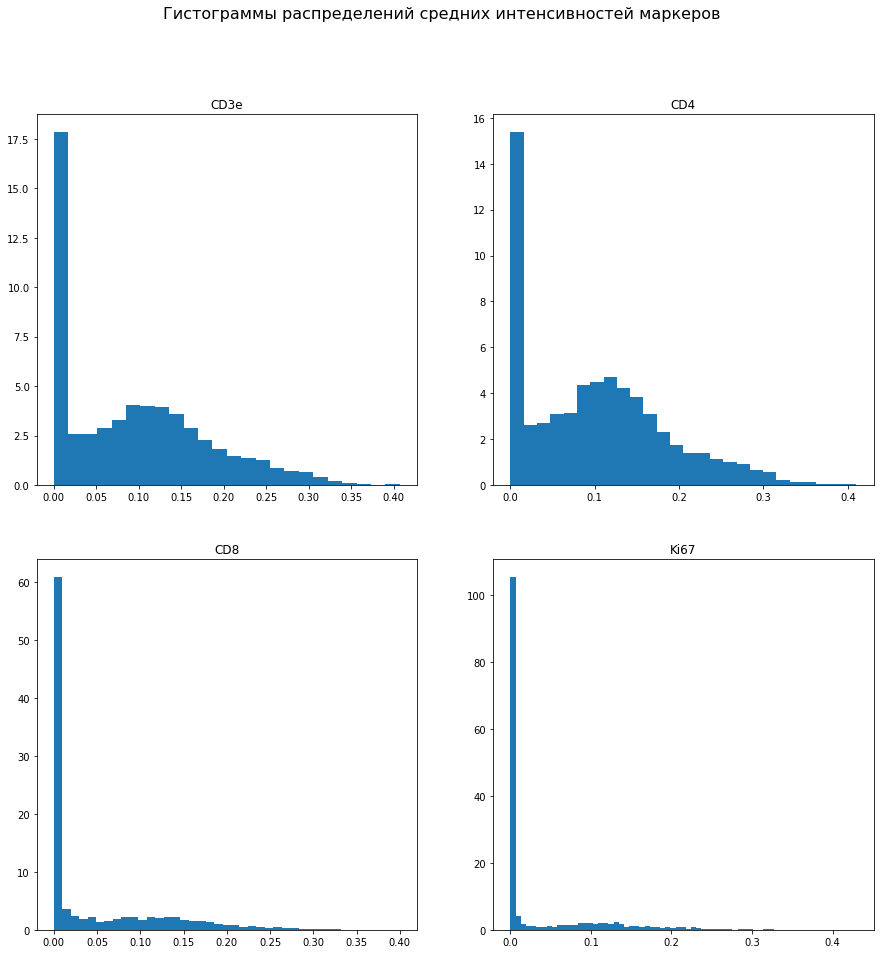

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab

f, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
axes = axes.flatten()

for idx, el in enumerate(['CD3e', 'CD4', 'CD8', 'Ki67']):
    n, bins, patches = axes[idx].hist(stats[:,idx], bins='auto', density=1)
    axes[idx].set_title(el)
#     Распределения представляют собой совокупность двух нормальных распределений, поэтому вывод графика общего нормального распределения смещен
#     (mu, sigma) = norm.fit(stats[:,idx])
#     y = norm.pdf(bins, mu, sigma)
#     axes[idx].plot(bins, y, 'r--', linewidth=2)
    
_ = f.suptitle('Гистограммы распределений средних интенсивностей маркеров', fontsize=16)

In [8]:
# Визуально установим границы классов клеток с экспрессией и без экспресии маркеров
threshs = [0.04, 0.04, 0.05, 0.05] #CD3e, CD4, CD8, Ki67

DAPI - ядерный маркер, Ki67 - маркер делящихся популяций клеток, CD3e, CD4, CD8 - мембранные маркеры Т-клеточных популяций, первый экспрессируется на всех Т-клетках, два последних - маркеры субпопуляций Т-клеток.<br />
Соответственно, имеем следующие возможные комбинации: <br />
1) Проверяем является ли клетка T-клеткой по CD3e<br />
2) У T-клеток проверяем наличи экспрессии CD4 или CD8 для разбиения на 2 субпопуляции<br />
3) Для 2-х субпопуляций, оставшихся Т-клеток и не Т-клеток определяем делящиеся они или нет<br />
<br />
Выводим статистику


In [9]:
# Индексы всех Т-клеток: неделящихся и делящихся
idxs_all_T_ndiv = []
idxs_all_T_div = []
# Индексы всех Т-клеток субпопуляции 1: неделящихся и делящихся
idxs_T1_ndiv = []
idxs_T1_div = []
# Индексы всех Т-клеток субпопуляции 2: неделящихся и делящихся
idxs_T2_ndiv = []
idxs_T2_div = []
# Индексы оставшихся клеток: неделящихся и делящихся
idxs_other_ndiv = []
idxs_other_div = []

for i, cell_props in enumerate(stats):
    if cell_props[0] > threshs[0]: # если клетка - Т-клетка
        
        if cell_props[3] > threshs[3]: # Т-клетка делящаяся
            idxs_all_T_div.append(i)
        else: # Т-клетка неделящаяся
            idxs_all_T_ndiv.append(i)
            
        if cell_props[1] > threshs[1] and cell_props[2] <= threshs[2]: # если клетка - Т-клетка 1-ой субпопуляции
            if cell_props[3] > threshs[3]: # Т1-клетка делящаяся
                idxs_T1_div.append(i)
            else: # Т1-клетка неделящаяся
                idxs_T1_ndiv.append(i)            
                
        if cell_props[2] > threshs[2] and cell_props[1] <= threshs[1]: # если клетка - Т-клетка 2-ой субпопуляции
            if cell_props[3] > threshs[3]: # Т2-клетка делящаяся
                idxs_T2_div.append(i)
            else: # Т2-клетка неделящаяся
                idxs_T2_ndiv.append(i)
        
    else: # клетка - не Т-клетка
        if cell_props[3] > threshs[3]: # делящаяся не Т-клетка
            idxs_other_div.append(i)
        else: # неделящаяся не Т-клетка
            idxs_other_ndiv.append(i)

In [10]:
print("Всего было найдено:", stats.shape[0], "клеток")
print("Из них:") 
print("Т клеток:", round(len(idxs_all_T_div) / stats.shape[0], 2), "(делящихся),",
      round(len(idxs_all_T_ndiv) / stats.shape[0], 2), "(неделящихся)")
print("\t Т клеток 1-ой субпопуляции:", round(len(idxs_T1_div) / stats.shape[0], 2), "(делящихся),",
      round(len(idxs_T1_ndiv) / stats.shape[0], 2), "(неделящихся)")
print("\t Т клеток 2-ой субпопуляции:", round(len(idxs_T2_div) / stats.shape[0], 2), "(делящихся),",
      round(len(idxs_T2_ndiv) / stats.shape[0], 2), "(неделящихся)")
print("Остальные клетки:", round(len(idxs_other_div) / stats.shape[0], 2), "(делящихся),",
      round(len(idxs_other_ndiv) / stats.shape[0], 2), "(неделящихся)")

Всего было найдено: 4783 клеток
Из них:
Т клеток: 0.13 (делящихся), 0.51 (неделящихся)
	 Т клеток 1-ой субпопуляции: 0.07 (делящихся), 0.24 (неделящихся)
	 Т клеток 2-ой субпопуляции: 0.01 (делящихся), 0.03 (неделящихся)
Остальные клетки: 0.12 (делящихся), 0.24 (неделящихся)


Populating the interactive namespace from numpy and matplotlib


C:\Users\denni\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm', 'f', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
C:\Users\denni\Anaconda3\envs\tensorflow\lib\site-packages\skimage\util\dtype.py:454: UserWarning: Downcasting uint32 to uint16 without scaling because max value 425 fits in uint16
  return convert(image, np.uint16, force_copy)


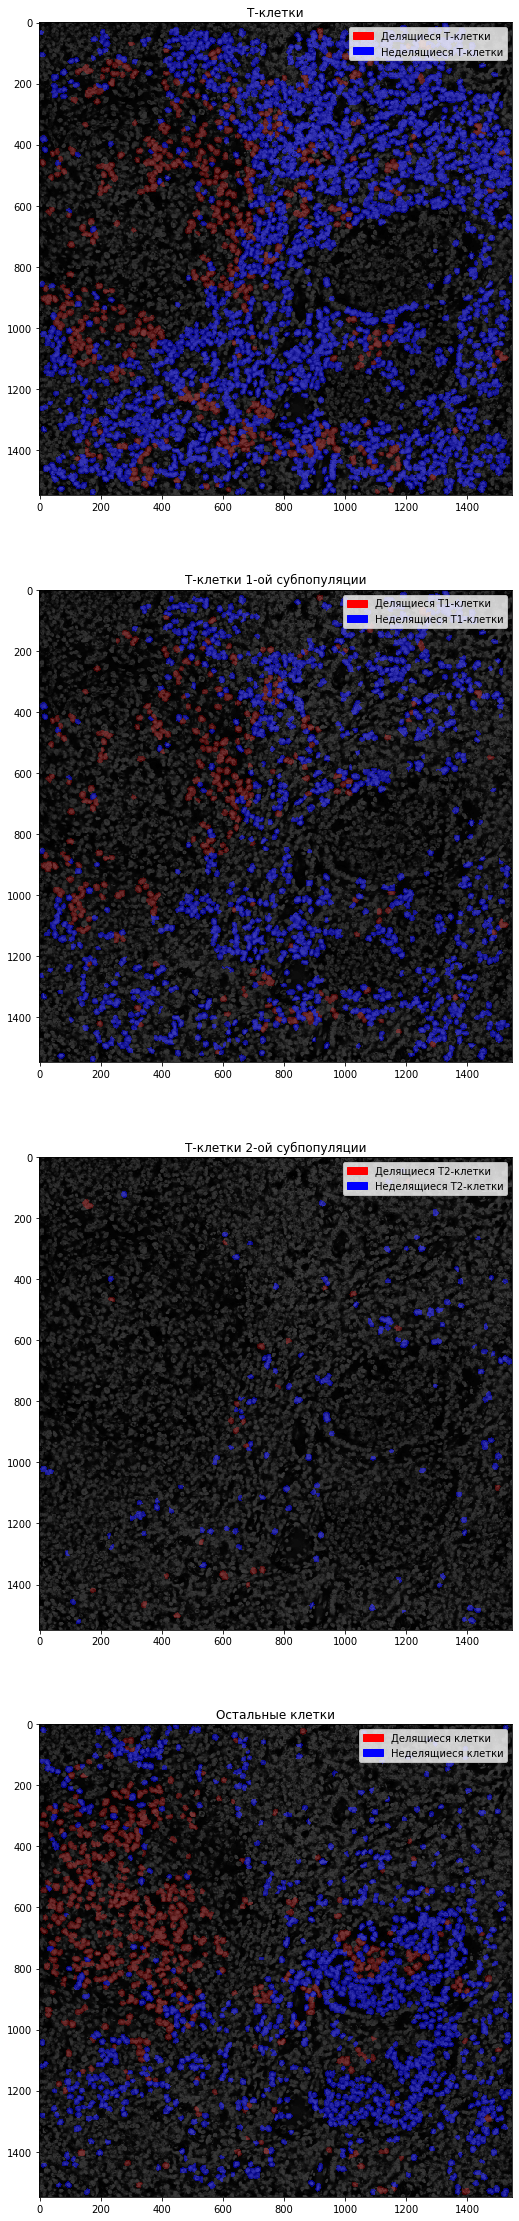

In [11]:
%pylab inline
# Отразим на суммарном серошкальном изображении всех каналов различные популяции клеток
from skimage import exposure
import matplotlib.patches as mpatches

I_sum = sum(imgs[0], axis=0)
I_sum = exposure.equalize_adapthist(I_sum, clip_limit=0.03)

def compose_label_from_idxs(L, idxs, color=(0, 0, 0)):
    BW = np.zeros(shape(L), dtype=bool) 
    for idx in idxs:
        BW |= L == idx + 1
    BW = np.array(BW, dtype=uint8) * 255
    result = np.stack((BW * color[0], BW * color[1], BW * color[2]), axis=-1)
    return result

f, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,40))

axes[0].imshow(I_sum, cmap = 'gray')
axes[0].imshow(compose_label_from_idxs(label_nuclei_expanded, idxs_all_T_div, color=(1, 0, 0)), alpha = 0.5)
axes[0].imshow(compose_label_from_idxs(label_nuclei_expanded, idxs_all_T_ndiv, color=(0, 0, 1)), alpha = 0.5)
_ = axes[0].set_title("T-клетки")
red_patch = mpatches.Patch(color='red', label='Делящиеся Т-клетки')
blue_patch = mpatches.Patch(color='blue', label='Неделящиеся Т-клетки')
_ = axes[0].legend(handles=[red_patch, blue_patch])

axes[1].imshow(I_sum, cmap = 'gray')
axes[1].imshow(compose_label_from_idxs(label_nuclei_expanded, idxs_T1_div, color=(1, 0, 0)), alpha = 0.5)
axes[1].imshow(compose_label_from_idxs(label_nuclei_expanded, idxs_T1_ndiv, color=(0, 0, 1)), alpha = 0.5)
_ = axes[1].set_title("T-клетки 1-ой субпопуляции")
red_patch = mpatches.Patch(color='red', label='Делящиеся Т1-клетки')
blue_patch = mpatches.Patch(color='blue', label='Неделящиеся Т1-клетки')
_ = axes[1].legend(handles=[red_patch, blue_patch])

axes[2].imshow(I_sum, cmap = 'gray')
axes[2].imshow(compose_label_from_idxs(label_nuclei_expanded, idxs_T2_div, color=(1, 0, 0)), alpha = 0.5)
axes[2].imshow(compose_label_from_idxs(label_nuclei_expanded, idxs_T2_ndiv, color=(0, 0, 1)), alpha = 0.5)
_ = axes[2].set_title("T-клетки 2-ой субпопуляции")
red_patch = mpatches.Patch(color='red', label='Делящиеся Т2-клетки')
blue_patch = mpatches.Patch(color='blue', label='Неделящиеся Т2-клетки')
_ = axes[2].legend(handles=[red_patch, blue_patch])

axes[3].imshow(I_sum, cmap = 'gray')
axes[3].imshow(compose_label_from_idxs(label_nuclei_expanded, idxs_other_div, color=(1, 0, 0)), alpha = 0.5)
axes[3].imshow(compose_label_from_idxs(label_nuclei_expanded, idxs_other_ndiv, color=(0, 0, 1)), alpha = 0.5)
_ = axes[3].set_title("Остальные клетки")
red_patch = mpatches.Patch(color='red', label='Делящиеся клетки')
blue_patch = mpatches.Patch(color='blue', label='Неделящиеся клетки')
_ = axes[3].legend(handles=[red_patch, blue_patch])

In [17]:
# Сатистика по средней интенсивности в каждой подгруппе клеток
print("Средняя интенсивность для неделящихся Т-клеток:",
      "\n CD3e:", round(np.mean(stats[idxs_all_T_ndiv, 0]), 2), u"\u00B1", round(np.std(stats[idxs_all_T_ndiv, 0]), 2),
      "\n CD4:", round(np.mean(stats[idxs_all_T_ndiv, 1]), 2), u"\u00B1", round(np.std(stats[idxs_all_T_ndiv, 1]), 2),
      "\n CD8:", round(np.mean(stats[idxs_all_T_ndiv, 2]), 2), u"\u00B1", round(np.std(stats[idxs_all_T_ndiv, 2]), 2),
      "\n Ki67:", round(np.mean(stats[idxs_all_T_ndiv, 3]), 2), u"\u00B1", round(np.std(stats[idxs_all_T_ndiv, 3]), 2))
print("Средняя интенсивность для делящихся Т-клеток:",
      "\n CD3e:", round(np.mean(stats[idxs_all_T_div, 0]), 2), u"\u00B1", round(np.std(stats[idxs_all_T_div, 0]), 2),
      "\n CD4:", round(np.mean(stats[idxs_all_T_div, 1]), 2), u"\u00B1", round(np.std(stats[idxs_all_T_div, 1]), 2),
      "\n CD8:", round(np.mean(stats[idxs_all_T_div, 2]), 2), u"\u00B1", round(np.std(stats[idxs_all_T_div, 2]), 2),
      "\n Ki67:", round(np.mean(stats[idxs_all_T_div, 3]), 2), u"\u00B1", round(np.std(stats[idxs_all_T_div, 3]), 2))

print("Средняя интенсивность для неделящихся Т1-клеток:",
      "\n CD3e:", round(np.mean(stats[idxs_T1_ndiv, 0]), 2), u"\u00B1", round(np.std(stats[idxs_T1_ndiv, 0]), 2),
      "\n CD4:", round(np.mean(stats[idxs_T1_ndiv, 1]), 2), u"\u00B1", round(np.std(stats[idxs_T1_ndiv, 1]), 2),
      "\n CD8:", round(np.mean(stats[idxs_T1_ndiv, 2]), 2), u"\u00B1", round(np.std(stats[idxs_T1_ndiv, 2]), 2),
      "\n Ki67:", round(np.mean(stats[idxs_T1_ndiv, 3]), 2), u"\u00B1", round(np.std(stats[idxs_T1_ndiv, 3]), 2))
print("Средняя интенсивность для делящихся Т1-клеток:",
      "\n CD3e:", round(np.mean(stats[idxs_T1_div, 0]), 2), u"\u00B1", round(np.std(stats[idxs_T1_div, 0]), 2),
      "\n CD4:", round(np.mean(stats[idxs_T1_div, 1]), 2), u"\u00B1", round(np.std(stats[idxs_T1_div, 1]), 2),
      "\n CD8:", round(np.mean(stats[idxs_T1_div, 2]), 2), u"\u00B1", round(np.std(stats[idxs_T1_div, 2]), 2),
      "\n Ki67:", round(np.mean(stats[idxs_T1_div, 3]), 2), u"\u00B1", round(np.std(stats[idxs_T1_div, 3]), 2))

print("Средняя интенсивность для неделящихся Т2-клеток:",
      "\n CD3e:", round(np.mean(stats[idxs_T2_ndiv, 0]), 2), u"\u00B1", round(np.std(stats[idxs_T2_ndiv, 0]), 2),
      "\n CD4:", round(np.mean(stats[idxs_T2_ndiv, 1]), 2), u"\u00B1", round(np.std(stats[idxs_T2_ndiv, 1]), 2),
      "\n CD8:", round(np.mean(stats[idxs_T2_ndiv, 2]), 2), u"\u00B1", round(np.std(stats[idxs_T2_ndiv, 2]), 2),
      "\n Ki67:", round(np.mean(stats[idxs_T2_ndiv, 3]), 2), u"\u00B1", round(np.std(stats[idxs_T2_ndiv, 3]), 2))
print("Средняя интенсивность для делящихся Т2-клеток:",
      "\n CD3e:", round(np.mean(stats[idxs_T2_div, 0]), 2), u"\u00B1", round(np.std(stats[idxs_T2_div, 0]), 2),
      "\n CD4:", round(np.mean(stats[idxs_T2_div, 1]), 2), u"\u00B1", round(np.std(stats[idxs_T2_div, 1]), 2),
      "\n CD8:", round(np.mean(stats[idxs_T2_div, 2]), 2), u"\u00B1", round(np.std(stats[idxs_T2_div, 2]), 2),
      "\n Ki67:", round(np.mean(stats[idxs_T2_div, 3]), 2), u"\u00B1", round(np.std(stats[idxs_T2_div, 3]), 2))

print("Средняя интенсивность для остальных клеток:",
      "\n CD3e:", round(np.mean(stats[idxs_other_ndiv, 0]), 2), u"\u00B1", round(np.std(stats[idxs_other_ndiv, 0]), 2),
      "\n CD4:", round(np.mean(stats[idxs_other_ndiv, 1]), 2), u"\u00B1", round(np.std(stats[idxs_other_ndiv, 1]), 2),
      "\n CD8:", round(np.mean(stats[idxs_other_ndiv, 2]), 2), u"\u00B1", round(np.std(stats[idxs_other_ndiv, 2]), 2),
      "\n Ki67:", round(np.mean(stats[idxs_other_ndiv, 3]), 2), u"\u00B1", round(np.std(stats[idxs_other_ndiv, 3]), 2))
print("Средняя интенсивность для остальных клеток:",
      "\n CD3e:", round(np.mean(stats[idxs_other_div, 0]), 2), u"\u00B1", round(np.std(stats[idxs_other_div, 0]), 2),
      "\n CD4:", round(np.mean(stats[idxs_other_div, 1]), 2), u"\u00B1", round(np.std(stats[idxs_other_div, 1]), 2),
      "\n CD8:", round(np.mean(stats[idxs_other_div, 2]), 2), u"\u00B1", round(np.std(stats[idxs_other_div, 2]), 2),
      "\n Ki67:", round(np.mean(stats[idxs_other_div, 3]), 2), u"\u00B1", round(np.std(stats[idxs_other_div, 3]), 2))

Средняя интенсивность для неделящихся Т-клеток: 
 CD3e: 0.14 ± 0.07 
 CD4: 0.11 ± 0.07 
 CD8: 0.06 ± 0.08 
 Ki67: 0.0 ± 0.01
Средняя интенсивность для делящихся Т-клеток: 
 CD3e: 0.16 ± 0.08 
 CD4: 0.11 ± 0.09 
 CD8: 0.04 ± 0.07 
 Ki67: 0.15 ± 0.07
Средняя интенсивность для неделящихся Т1-клеток: 
 CD3e: 0.14 ± 0.07 
 CD4: 0.13 ± 0.06 
 CD8: 0.01 ± 0.01 
 Ki67: 0.0 ± 0.01
Средняя интенсивность для делящихся Т1-клеток: 
 CD3e: 0.16 ± 0.08 
 CD4: 0.16 ± 0.07 
 CD8: 0.0 ± 0.01 
 Ki67: 0.15 ± 0.06
Средняя интенсивность для неделящихся Т2-клеток: 
 CD3e: 0.14 ± 0.07 
 CD4: 0.01 ± 0.01 
 CD8: 0.14 ± 0.05 
 Ki67: 0.0 ± 0.01
Средняя интенсивность для делящихся Т2-клеток: 
 CD3e: 0.14 ± 0.08 
 CD4: 0.01 ± 0.01 
 CD8: 0.13 ± 0.06 
 Ki67: 0.13 ± 0.06
Средняя интенсивность для остальных клеток: 
 CD3e: 0.01 ± 0.01 
 CD4: 0.07 ± 0.09 
 CD8: 0.03 ± 0.06 
 Ki67: 0.0 ± 0.01
Средняя интенсивность для остальных клеток: 
 CD3e: 0.0 ± 0.01 
 CD4: 0.1 ± 0.11 
 CD8: 0.01 ± 0.04 
 Ki67: 0.13 ± 0.05


In [20]:
# Статистика по числу контактов с другими типами клеток
from skimage.morphology import binary_dilation, disk
from skimage.measure import label

def L_all(L, idxs):
    BW = np.zeros(shape(L), dtype=bool) 
    for idx in idxs:
        BW |= L == idx + 1
    return BW

all_idxs = [idxs_all_T_ndiv, idxs_all_T_div,
             idxs_T1_ndiv, idxs_T1_div,
             idxs_T2_ndiv, idxs_T2_div,
             idxs_other_ndiv, idxs_other_div]

connectivity_stats = np.zeros((len(all_idxs), len(all_idxs)), dtype=np.uint32)

se = disk(radius = 6) # мембрана толщиной 5 пикселей, для детектирования необходимо выбрать размер на 1 пикселей больше

for i, idxs1 in enumerate(all_idxs):
    BW1 = L_all(label_nuclei, idxs1)
    BW1 = binary_dilation(BW1, se)
    for j, idxs2 in enumerate(all_idxs):
        BW2 = L_all(label_nuclei, idxs2)
        BW2 = binary_dilation(BW2, se)
        _, num = label(BW1 & BW2, return_num=True)
        connectivity_stats[i, j] = num

In [27]:
import pandas as pd
def highlight_diag(df):
    a = np.full(df.shape, '', dtype='<U24')
    np.fill_diagonal(a, 'background-color: yellow')
    return pd.DataFrame(a, index=df.index, columns=df.columns)



idx_names = col_names = ['T_ndiv', 'T_div',
                         'T1_ndiv', 'T1_div',
                         'T2_ndiv', 'T2_div',
                         'other_ndiv', 'other_div']
df = pd.DataFrame(connectivity_stats, index = idx_names, columns = col_names)
df.style.apply(highlight_diag, axis=None)

,T_ndiv,T_div,T1_ndiv,T1_div,T2_ndiv,T2_div,other_ndiv,other_div
T_ndiv,257,332,361,192,101,23,671,104
T_div,332,204,202,163,20,25,74,148
T1_ndiv,361,202,361,140,58,6,371,51
T1_div,192,163,140,163,6,7,31,90
T2_ndiv,101,20,58,6,101,5,62,6
T2_div,23,25,6,7,5,25,8,9
other_ndiv,671,74,371,31,62,8,360,146
other_div,104,148,51,90,6,9,146,207
